In this notebook we will explore XGboost to build collection of boosted tree, and use continuous and categorical data from the IBM Base samples to predict whether or not customer will stop using a company's service. In business lingo, this is called customer churn, you can download the [telco churn dataset](https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=samples-telco-customer-churn).

In [1]:
# import dependancy
import pandas as pd  # ver = 0.25.1
import numpy as np  # ver => 1.17.2
import xgboost as xgb # ver = 0.90
from sklearn.model_selection import train_test_split # ver => 0.22.1
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV #cross validation
from sklearn.metrics import confusion_matrix # create a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay #draws a confusion matrix
import matplotlib.pyplot as plt

In [2]:
xgb.__version__

'0.90'

### Lets do some EDA

In [3]:
# import data
data = pd.read_csv("IBM_Telco_Chrun_db/Telco-Customer-Churn.csv")

In [4]:
df = data.copy() # backup for original data

In [5]:
df.shape

(7043, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In above data if yoe found the columns that exit interview information or unrelated columns which should not be used for prediction, so will remove them by using following command.

In [8]:
# df.drop(["Name_of_column"], axis= 1, inplace= True) # axis = 1 mesns we dropping coloum, inplace= True means we are not making copy of df we modifing original df
# df.head()

In [9]:
# Check columns unique values
df_col =df[0:0]
for i in df_col:
    print(i+ " : ")
    print(df[i].unique(), "\n")

customerID : 
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

gender : 
['Female' 'Male'] 

SeniorCitizen : 
[0 1] 

Partner : 
['Yes' 'No'] 

Dependents : 
['No' 'Yes'] 

tenure : 
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] 

PhoneService : 
['No' 'Yes'] 

MultipleLines : 
['No phone service' 'No' 'Yes'] 

InternetService : 
['DSL' 'Fiber optic' 'No'] 

OnlineSecurity : 
['No' 'Yes' 'No internet service'] 

OnlineBackup : 
['Yes' 'No' 'No internet service'] 

DeviceProtection : 
['No' 'Yes' 'No internet service'] 

TechSupport : 
['No' 'Yes' 'No internet service'] 

StreamingTV : 
['No' 'Yes' 'No internet service'] 

StreamingMovies : 
['No' 'Yes' 'No internet service'] 

Contract : 
['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling : 
['Yes' 'No'] 

PaymentM

Note: From above observation, each column have 2 or more than 2 unique element, we can use them for analysis, Of column with only 1 unique value we can not use it because it not influence our prediction

We will also remove "customerID" coloum, because it is different for every customer and useless for classification.

In [10]:
df.drop(["customerID"], axis = 1, inplace = True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Note: 
Although it is OK to have whitespace in the "MultipleLines", "InternetService", "Contract", or may me more.. for XGBoost and classification, we can't have any whitespace if we want to draw a tree. So let's take care of now by replacing the white space in the city name with an underscore character "_" .
##### Also note:  We can easily remove whitespaces from all values, but we will wait to do that until after we have identified missing values.

In [11]:
# Check for missing value
df.isnull().sum()
# No missing value, we ready to move further

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [12]:
# Remoiving whitespace from coloums 
#["MultipleLines", "InternetService", "OnlineBackup", "TechSupport","StreamingTV", "StreamingMovies", "Contract","PaymentMethod"]
list_catagical_col = ["MultipleLines", "InternetService", "OnlineBackup",
                       "TechSupport","StreamingTV", "StreamingMovies", "Contract",
                       "PaymentMethod"]
for i in list_catagical_col:
    df[i].replace(" ", "_", regex= True, inplace= True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


In [13]:
# If there is whitespace in coloum name, in given data we have not seen such pattern. if found use following method
df.columns = df.columns.str.replace(" ", "_")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


We have remove all data that will not help to use create XGBoost model.

## Missing Data : Identifying missing data
1. The first part of this process is identifying missing Data
        Missing data simply a blank space or surrogated value line NA, Null, NaN, or 0 we have to identify it.
##### One thing is relatively unique about XGBoost is that it has default behaviou for missing data. SO all we have to do is identify missing values and make sure they are set to "0". [check doc.](https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values)


In [14]:
# Check for data type in each coloum
df.dtypes # this gona tell us is something is mess up or not

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [15]:
df_col =df.columns
for i in df_col:
    print(i+ " : ", df[i].dtypes)
    print(df[i].unique(), "\n")
# Here we check for unexpected value in coloum like "?, /, <unknown char>, etc.."
# All look GOOD!

gender :  object
['Female' 'Male'] 

SeniorCitizen :  int64
[0 1] 

Partner :  object
['Yes' 'No'] 

Dependents :  object
['No' 'Yes'] 

tenure :  int64
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] 

PhoneService :  object
['No' 'Yes'] 

MultipleLines :  object
['No_phone_service' 'No' 'Yes'] 

InternetService :  object
['DSL' 'Fiber_optic' 'No'] 

OnlineSecurity :  object
['No' 'Yes' 'No internet service'] 

OnlineBackup :  object
['Yes' 'No' 'No_internet_service'] 

DeviceProtection :  object
['No' 'Yes' 'No internet service'] 

TechSupport :  object
['No' 'Yes' 'No_internet_service'] 

StreamingTV :  object
['No' 'Yes' 'No_internet_service'] 

StreamingMovies :  object
['No' 'Yes' 'No_internet_service'] 

Contract :  object
['Month-to-month' 'One_year' 'Two_year'] 

PaperlessBilling :  object
['Yes' 'No'] 


### Note:
If we look at the output from above two cell, for coloum "TotalCharges", looklike it contain numbers , not text.
but the object datatype suggests that it contains more than just number.

Let's check it and try to convert its datatype.

In [16]:
# df["TotalCharges"]= pd.to_numeric(df['TotalCharges']) # This gives the error

Here i add screen shot, in case you did not get error
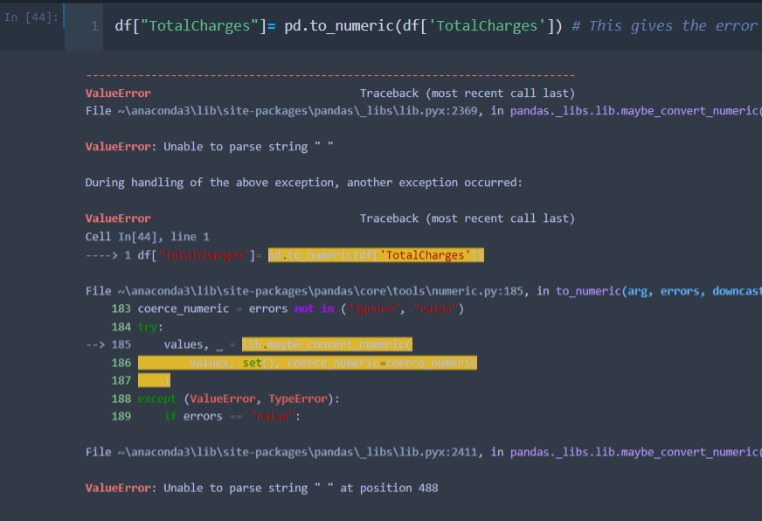

Above error tell, There are blank spaces, " " , in the data, so we need to deal with those

# Missing Data: Dealing with missing data, XGBoost style

XGBoost is determines default behavior for missing data,
so we have to identify missing values and make sure they are set to 0.

Before we do that lets check how many rows are missingdata.

If it's a lot. Then we might have a problem on our hands that is bigger than what XGBoost can deal with on its own.

IF it's not that many, we can just set them to 0.

In [17]:
len(df.loc[df['TotalCharges'] == ' ']) # .loc() , gives the location of row/col where condication in finction True

#to check for all coloum 
# col = df.columns
# for i in col:
#     print(i, "\n")
#     print(len(df.loc[df[i] == ' ']))

11

since only 11 rows have missing values, lets look at them.

In [18]:
df.loc[df['TotalCharges'] == ' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,Yes,Bank_transfer_(automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,No,Mailed_check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,No,Credit_card_(automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,One_year,Yes,Mailed_check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,No,Mailed_check,73.35,,No


In [19]:
## Original Data
data.loc[df['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


We see that all **11** people with "TotalCharges" == " " , have just signed up, because "tenure" is **0**.

if we check original data i.e. before EDA, we can see

These peope also all have 'Chrun' == No, because they just signed up!!

So have few choice here, we can set "TotalCharges" to **0** Or we can remove them.

in this example, we'll try setting "TotalCharges" to 0

In [20]:
df.loc[(df["TotalCharges"] == " "), "TotalCharges"] = 0

Now let's verify that we modified **TotalCharges** correctly by looking at everyone who had tenure months set 0

In [21]:
df.loc[df['TotalCharges'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,Yes,Bank_transfer_(automatic),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,No,Mailed_check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,No,Credit_card_(automatic),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No_internet_service,No internet service,No_internet_service,No_internet_service,No_internet_service,One_year,Yes,Mailed_check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,No,Mailed_check,73.35,0,No


We verified that df contains 0's insted " ", for missing value.

But "TotalCharges" still have Object data type, we have to convert it into numeric data type

In [22]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"]) # convert data type
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [23]:
# you can replace all whitespace from data to "_" with following command
df.replace(' ', '_', regex= True, inplace = True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


## Format Data: Split the data into Dependant and independant variable
- Now start fromatting data for XGBoost
1. Split data into two part:

    i) the columns of data that we will use to make classifications
    
    ii) the column of data that we want to predict
    
 We will use, **X** to represent the columns of data that will make classification.
             
   and **y** to represent the thing we want to predict i.e. **'Chrun'** 
      
 First thing first, convert "Chrun" value from categorical to Numeric
 
 i.e. for 'yes' = 1 , 'No' = 0

In [24]:
# Convert "Churn" value  for 'yes' = 1 , 'No' = 0
df.loc[(df["Churn"] == "Yes"), "Churn"] = 1
df.loc[(df["Churn"] == "No"), "Churn"] = 0
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1


In [25]:
# Split data

X = df.drop("Churn", axis = 1).copy()
# We use copy() to protect our "No missing data" from any mistake, as backup
X.head()  # data use foe prediction

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [26]:
y = df["Churn"].copy()
y.head() # predict data

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: object

#### Let's start formatting **X** so that suitable for XGBoost

# Formatting Data: One-Hot Encoding

As we know: we have data columns name, there data type and Unique value, as below,
    
gender :  object

['Female' 'Male'] 


SeniorCitizen :  int64

[0 1] 


Partner :  object

['Yes' 'No'] 


Dependents :  object

['No' 'Yes'] 


tenure :  int64

[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] 
 

PhoneService :  object

['No' 'Yes'] 


MultipleLines :  object

['No_phone_service' 'No' 'Yes'] 


InternetService :  object

['DSL' 'Fiber_optic' 'No'] 


OnlineSecurity :  object

['No' 'Yes' 'No internet service'] 


OnlineBackup :  object

['Yes' 'No' 'No_internet_service'] 


DeviceProtection :  object

['No' 'Yes' 'No internet service'] 


TechSupport :  object

['No' 'Yes' 'No_internet_service'] 


StreamingTV :  object

['No' 'Yes' 'No_internet_service'] 


StreamingMovies :  object

['No' 'Yes' 'No_internet_service'] 


Contract :  object

['Month-to-month' 'One_year' 'Two_year'] 


PaperlessBilling :  object

['Yes' 'No'] 


PaymentMethod :  object

['Electronic_check' 'Mailed_check' 'Bank_transfer_(automatic)'
 'Credit_card_(automatic)'] 
 

MonthlyCharges :  float64

[29.85 56.95 53.85 ... 63.1  44.2  78.7 ] 


TotalCharges : float64

['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5'] 

**In Data, we have buch of catagorical data type columns, Now we are going to convert it into Numerical data**

Catagorical data induced discontinuty, hence bunch of machine learning alorithum not support catagorical datatype.

so we goan conver it into multiple binary values Using **One-Hot Encoding**.

There are many ways to do one-hot encoding, sklearn provied module "ColumnTransfomer()", but it has down side when new data input comes in production it will throgh error.

and another way to do one-hot encoding using "get_dummies()", get_dummies() leaves your data in dataframe and ratains the column name, making it much easier to verify that it worked ad intended,

however it dosen't have persistent behavior that ColumnTransfomer() has.

In [27]:
# Lets apply One hot encoding as test on single column to check if we get approprite output
pd.get_dummies(X, columns= ["PaymentMethod"]).head()
# check last four coloumns

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,...,No,No,Month-to-month,Yes,29.85,29.85,0,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One_year,No,56.95,1889.50,0,0,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,...,No,No,One_year,No,42.30,1840.75,1,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0


##### Let's do One-Hot encoding for all categical data coloum 

In [28]:
X_encoded = pd.get_dummies(X, columns= ["gender", "Partner", "Dependents", "PhoneService",
      "MultipleLines", "InternetService", "OnlineSecurity",
      "OnlineBackup", "DeviceProtection", "TechSupport", 
      "StreamingTV", "StreamingMovies", "Contract", 
      "PaperlessBilling", "PaymentMethod"])
X_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


#### One last thing verify pridict data i.e. y, contain only **1's** and **0's**

In [29]:
y.unique()

array([0, 1], dtype=object)

# Build Preliminary XGBoost model

#### First observe that data imbalance, by dividing the numbre of people who left the company,
#### where  y = 1, by the total number of people in dataset.

In [30]:
sum(y)/len(y)

0.2653698707936959

We can see 27% of people in dataset leave the company


Because of this when we split data into train and test, 
we will split using stratification in order to maintain the same percentage of people who left the company in both the tranining set and testing set.

### Split data into training and testing 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state= 42, stratify= y)

#### Let's check **stratify** work or not !!

In [32]:
sum(y_test)/len(y_test)

0.26519023282226006

In [33]:
sum(y_train)/len(y_train)

0.2654297614539947

### both y_train and y_test have same percentage of people that left company

**Note** : Insted of determining the optimal number of tree with cross validation, we will use **early stoping** to stop building tree when they not longer improve the situation

In [34]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic", missing= None, seed = 42)
                        # objective  ="binary:logistic", xgboost use it to classify object using logistic regression  
    
clf_xgb.fit(X_train,
           y_train,
           verbose= True, 
           early_stopping_rounds= 10, # when tree not progrss after certain vlaue we are extend tree by 10 trees and stop
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.579067
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.581273
[2]	validation_0-aucpr:0.594607
[3]	validation_0-aucpr:0.595215
[4]	validation_0-aucpr:0.596482
[5]	validation_0-aucpr:0.598574
[6]	validation_0-aucpr:0.631769
[7]	validation_0-aucpr:0.638008
[8]	validation_0-aucpr:0.638729
[9]	validation_0-aucpr:0.63937
[10]	validation_0-aucpr:0.63839
[11]	validation_0-aucpr:0.641466
[12]	validation_0-aucpr:0.641945
[13]	validation_0-aucpr:0.641556
[14]	validation_0-aucpr:0.640274
[15]	validation_0-aucpr:0.64372
[16]	validation_0-aucpr:0.645566
[17]	validation_0-aucpr:0.645732
[18]	validation_0-aucpr:0.647367
[19]	validation_0-aucpr:0.64633
[20]	validation_0-aucpr:0.647219
[21]	validation_0-aucpr:0.647022
[22]	validation_0-aucpr:0.647085
[23]	validation_0-aucpr:0.649197
[24]	validation_0-aucpr:0.650565
[25]	validation_0-aucpr:0.649892
[26]	validation_0-aucpr:0.649925
[27]	validation_0-aucpr:0.649745
[28]	validation_0-aucpr:

XGBClassifier(seed=42)

#### NOTE: best result we get until 40 tree and after that we extend 10 tree 

We build an XGBoost model for classification.

Let's test performance on testing dataset and draw confusion matrix

In [35]:
y_predicted = clf_xgb.predict(X_test)
y_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [36]:
# from sklearn.metrics import confusion_matrix
y_true = list(y_test)
y_pred = list(y_predicted)
cm= confusion_matrix(y_true, y_pred)
print(cm)

[[1186  108]
 [ 242  225]]


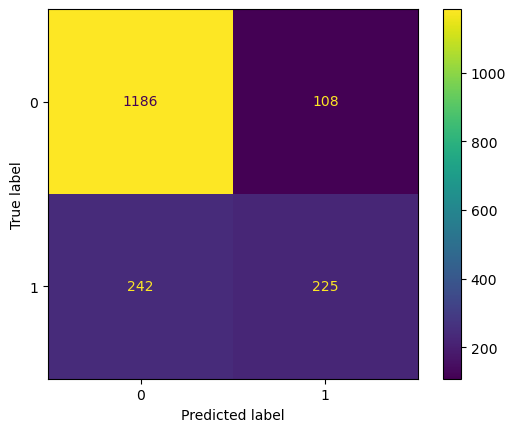

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf_xgb.classes_)
disp.plot()
plt.show()

In confusiin matrix the top row **1294** people that did not leave the company, where **1186** people correctly classifide i.e. about **67.35%**.

And **467** people left the company, where **225** people correctly classifide as Left company i.e. about only **12.78%** !!

So **XGBoost** was not awesome.

To make it Awesome we have to capture more of the people that left.

**The good news is that XGBoost has a parameter, "scale_pos_weight", that helps with imbalance data.**

SO let's try improve prediction using **Cross Validation** to optimize the parameter.

# Optimize parameters using cross Validation and GridSearch()

The option we have to Optimize XGBoost hyperparameter are,
1. "max_depth" : determine maximum depth of tree
2. "learning_rate" : the learning rate, "eta" or 
3. "gamma" : the parameter thet encourages pruning  (The gamma parameter in XGBoost is a pseudo-regularization hyperparameter that controls the complexity of the model. It is also known as the Lagrangian multiplier 1. The higher the gamma value, the higher the regularization, which helps to prevent overfitting 1. The default value of gamma is 0, which means no regularization )
4. "reg_lambda" : the regularization parameter lambda
.

.

.

etc...

But we are going with "GridSearchCV()", 

We specify a bunch of potential values for the hyperparameter and "GridSearchCV()" test all possible combination of the parameter for us.

In [39]:
## Note: When data imblanced, the Xgboost manual says, use AUC for evaluation 

# ## Round 1:
# param_grid= {
#     "max_depth": [3,4,5],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma" : [0, 0.25, 1.0],
#     "reg_lamda" : [0, 1.0, 10.0], # normalization
#     "scale_pos_weight" : [1, 3, 5] # Note: XGBoost recommend sum(negative instance)/ sum(positive instance))
    
# }
# # output: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lamda': 0, 'scale_pos_weight': 1}

# Round 2:
param_grid= {
    "max_depth": [3],
    "learning_rate": [0.1, 0.5, 1],
    "gamma" : [0],
    "reg_lamda" : [10.0, 20, 100], 
    "scale_pos_weight" : [1] # Note: XGBoost recommend sum(negative instance)/ sum(positive instance))
    
}

# # output:{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lamda': 10.0, 'scale_pos_weight': 1}

## Note: To speed up cross validation and to futher prevent overfittiong,
## we are only using a random subset of the data (90%) and are only using a random subset of the feature 50% per tree.

optimal_params = GridSearchCV( 
    estimator= xgb.XGBClassifier( objective= 'binary:logistic',
                                                    seed = 42,
                                                    subsample=0.9,
                                                    colsample_bylevel= 0.5),
    param_grid = param_grid,
    scoring= 'roc_auc',
    verbose=2, # If you want to see what grid search doing set verbose =2
    n_jobs= 10,
    cv = 3
)

optimal_params.fit(X_train,
           y_train,
           verbose= True, 
           early_stopping_rounds= 10, # when tree not progrss after certain vlaue we are extend tree by 10 trees and stop
           eval_metric='auc',
           eval_set=[(X_test, y_test)])

print(optimal_params.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[0]	validation_0-auc:0.803607
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.829579
[2]	validation_0-auc:0.833527
[3]	validation_0-auc:0.833921
[4]	validation_0-auc:0.837415
[5]	validation_0-auc:0.836726
[6]	validation_0-auc:0.838382
[7]	validation_0-auc:0.83886
[8]	validation_0-auc:0.839215
[9]	validation_0-auc:0.840687
[10]	validation_0-auc:0.840463
[11]	validation_0-auc:0.841402
[12]	validation_0-auc:0.84177
[13]	validation_0-auc:0.841782
[14]	validation_0-auc:0.841859
[15]	validation_0-auc:0.842784
[16]	validation_0-auc:0.842837
[17]	validation_0-auc:0.843649
[18]	validation_0-auc:0.844374


C:\Users\ajitw\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[19]	validation_0-auc:0.844597
[20]	validation_0-auc:0.844976
[21]	validation_0-auc:0.845019
[22]	validation_0-auc:0.845056
[23]	validation_0-auc:0.845116
[24]	validation_0-auc:0.845483
[25]	validation_0-auc:0.845605
[26]	validation_0-auc:0.845308
[27]	validation_0-auc:0.845265
[28]	validation_0-auc:0.845474
[29]	validation_0-auc:0.846255
[30]	validation_0-auc:0.846701
[31]	validation_0-auc:0.846783
[32]	validation_0-auc:0.846725
[33]	validation_0-auc:0.846669
[34]	validation_0-auc:0.846971
[35]	validation_0-auc:0.847241
[36]	validation_0-auc:0.847664
[37]	validation_0-auc:0.847751
[38]	validation_0-auc:0.848107
[39]	validation_0-auc:0.848085
[40]	validation_0-auc:0.848466
[41]	validation_0-auc:0.848763
[42]	validation_0-auc:0.848892
[43]	validation_0-auc:0.84919
[44]	validation_0-auc:0.849372
[45]	validation_0-auc:0.849238
[46]	validation_0-auc:0.849389
[47]	validation_0-auc:0.849409
[48]	validation_0-auc:0.84931
[49]	validation_0-auc:0.849334
[50]	validation_0-auc:0.84936
[51]	valida

**we optimize model, the best parameter we got are {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lamda': 10.0, 'scale_pos_weight': 1}**

# Building, Evaluating, Drawing ad Interpreting the Optimize XGBoost model

In [40]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic",
                            missing= None,
                            seed = 42,
                            gamma= 0,
                            learn_rate= 0.1,
                            max_depth = 3,
                            reg_lambda= 10,
                            scale_pos_weight= 1,
                            subsample=0.9,
                            colsample_bytree= 0.5)
    
clf_xgb.fit(X_train,
           y_train,
           verbose= True, 
           early_stopping_rounds= 10, # when tree not progrss after certain vlaue we are extend tree by 10 trees and stop
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.500861
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.61354
[2]	validation_0-aucpr:0.622324
[3]	validation_0-aucpr:0.617213
[4]	validation_0-aucpr:0.614286
[5]	validation_0-aucpr:0.621167
[6]	validation_0-aucpr:0.626256
[7]	validation_0-aucpr:0.630771
[8]	validation_0-aucpr:0.632927
[9]	validation_0-aucpr:0.632742
[10]	validation_0-aucpr:0.624845
[11]	validation_0-aucpr:0.637875
[12]	validation_0-aucpr:0.638571
[13]	validation_0-aucpr:0.638906
[14]	validation_0-aucpr:0.640775
[15]	validation_0-aucpr:0.640752
[16]	validation_0-aucpr:0.640097
[17]	validation_0-aucpr:0.641898
[18]	validation_0-aucpr:0.644031
[19]	validation_0-aucpr:0.645299
[20]	validation_0-aucpr:0.645799
[21]	validation_0-aucpr:0.648746
[22]	validation_0-aucpr:0.649443
[23]	validation_0-aucpr:0.649811
[24]	validation_0-aucpr:0.647221
[25]	validation_0-aucpr:0.647561
[26]	validation_0-aucpr:0.647163
[27]	validation_0-aucpr:0.649058
[28]	validation_0-auc

XGBClassifier(colsample_bytree=0.5, learn_rate=0.1, reg_lambda=10, seed=42,
              subsample=0.9)

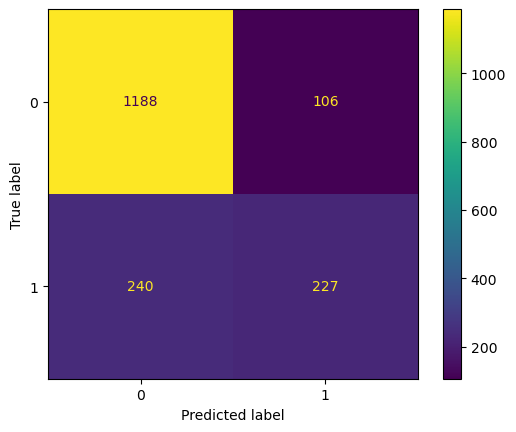

In [41]:
y_predicted = clf_xgb.predict(X_test)
# y_predicted

# from sklearn.metrics import confusion_matrix
y_true = list(y_test)
y_pred = list(y_predicted)
cm= confusion_matrix(y_true, y_pred)
# print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf_xgb.classes_)
disp.plot()
plt.show()

In [42]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic",
                            seed = 42,
                            gamma= 0.25,
                            learn_rate= 0.1,
                            max_depth = 4,
                            reg_lambda= 10,
                            scale_pos_weight= 3,
                            subsample=0.9,
                            colsample_bytree= 0.5)
    
clf_xgb.fit(X_train,
           y_train,
           verbose= True, 
           early_stopping_rounds= 10, # when tree not progrss after certain vlaue we are extend tree by 10 trees and stop
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.509761
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.574645
[2]	validation_0-aucpr:0.591234
[3]	validation_0-aucpr:0.595405
[4]	validation_0-aucpr:0.588641
[5]	validation_0-aucpr:0.605818
[6]	validation_0-aucpr:0.6112
[7]	validation_0-aucpr:0.632353
[8]	validation_0-aucpr:0.63268
[9]	validation_0-aucpr:0.63283
[10]	validation_0-aucpr:0.637173
[11]	validation_0-aucpr:0.644481
[12]	validation_0-aucpr:0.646045
[13]	validation_0-aucpr:0.638277
[14]	validation_0-aucpr:0.63761
[15]	validation_0-aucpr:0.638123
[16]	validation_0-aucpr:0.639365
[17]	validation_0-aucpr:0.642851
[18]	validation_0-aucpr:0.642439
[19]	validation_0-aucpr:0.639868
[20]	validation_0-aucpr:0.643915
[21]	validation_0-aucpr:0.645688
[22]	validation_0-aucpr:0.64588
Stopping. Best iteration:
[12]	validation_0-aucpr:0.646045



XGBClassifier(colsample_bytree=0.5, gamma=0.25, learn_rate=0.1, max_depth=4,
              reg_lambda=10, scale_pos_weight=3, seed=42, subsample=0.9)

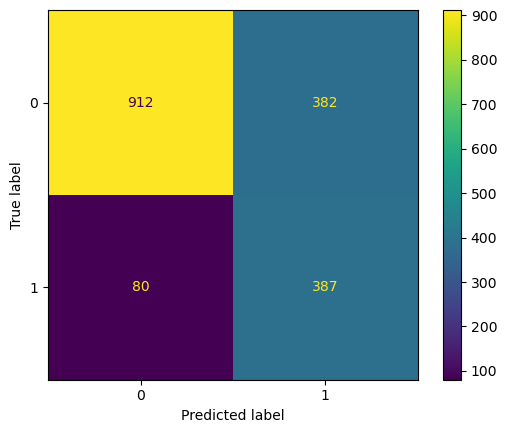

In [43]:
y_predicted = clf_xgb.predict(X_test)
# y_predicted

# from sklearn.metrics import confusion_matrix
y_true = list(y_test)
y_pred = list(y_predicted)
cm= confusion_matrix(y_true, y_pred)
# print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf_xgb.classes_)
disp.plot()
plt.show()

We got progress!!
In confusiin matrix the top row **1294** people that did not leave the company, where **912** people correctly classifide i.e. about **51.8%**.

And **407** people left the company, where **387** people correctly classifide as Left company i.e. about only **22%** !!

Awesome !

### Let's Draw the tree

weight:  {'Contract_Month-to-month': 1, 'MonthlyCharges': 7, 'Contract_Two_year': 2, 'StreamingMovies_Yes': 1, 'Dependents_Yes': 1, 'OnlineBackup_No': 1, 'InternetService_DSL': 1}
gain:  {'Contract_Month-to-month': 1631.77637, 'MonthlyCharges': 59.07611061857143, 'Contract_Two_year': 22.18716815, 'StreamingMovies_Yes': 15.2282104, 'Dependents_Yes': 5.58708954, 'OnlineBackup_No': 81.4244843, 'InternetService_DSL': 67.1963501}
cover:  {'Contract_Month-to-month': 1820.25, 'MonthlyCharges': 443.7857142857143, 'Contract_Two_year': 304.75, 'StreamingMovies_Yes': 208.5, 'Dependents_Yes': 97.5, 'OnlineBackup_No': 432.0, 'InternetService_DSL': 778.75}
total_gain:  {'Contract_Month-to-month': 1631.77637, 'MonthlyCharges': 413.53277433, 'Contract_Two_year': 44.3743363, 'StreamingMovies_Yes': 15.2282104, 'Dependents_Yes': 5.58708954, 'OnlineBackup_No': 81.4244843, 'InternetService_DSL': 67.1963501}
total_cover:  {'Contract_Month-to-month': 1820.25, 'MonthlyCharges': 3106.5, 'Contract_Two_year': 60

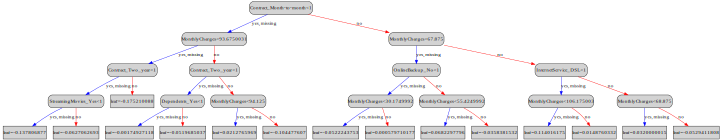

In [44]:
## IF we want to get information like gain and covet etc. at each node in thefirst tree,
## we just build the first tree, otherwise we'll get Average over all of tree.

clf_xgb = xgb.XGBClassifier(objective="binary:logistic",
                            seed = 42,
                            gamma= 0.25,
                            learn_rate= 0.1,
                            max_depth = 4,
                            reg_lambda= 10,
                            scale_pos_weight= 3,
                            subsample=0.9,
                            colsample_bytree= 0.5,
                            n_estimators = 1) ## we set this to 1 so we can get gain, cover, etc..
    
clf_xgb.fit(X_train, y_train)

## now peint out the weight, gain, cover etc 
## weight = number of times a feature is used in a branch or root across all  tree
## gain = the averange gain across all splits that the feature is used in
## cover = the averange coverrange acreoss all splits a feature is used in
## total_gain = the total_gain across all splits the feature is used in
## total_cover = the total_cover across all splits the feature is used in

## Note: since we only build one tree gain= total gain and cover = total cover
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type= importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolour': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolour': '#e48038'}

## Note = Num_tree is NOT the number of tree to plot, but the specific tree you want to plot
## counter-intuitive
## xgb.to_graphviz(clf_xgb, num_tree = 0, size ="10,10")
xgb.to_graphviz(clf_xgb, num_trees=0, size =  "10,10",
               condition_node_params= node_params,
               leaf_node_params= leaf_params)

# ## if you want to save fig..
# graph_data= xgb.to_graphviz(clf_xgb, num_trees=0, size =  "10,10",
#                condition_node_params= node_params,
#                leaf_node_params= leaf_params)
# graph_data.view(filename = "xgboost_tree_customer_churn") # save as pdf